# Energy budget from Ketura paper

The objective of this script is to calculate and create the energy budget diurnal graphs

In [85]:
import pandas as pd
import openpyxl
import numpy as np
import glob
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal

### Input and output paths

In [86]:
project_path = 'D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/'   # Weizmann desktop
#project_path = 'C:/Users/rafas/Dropbox/Doutorado/Working/Ketura/'     # notebook
input_path   = project_path + '01_data/'
output_path  = project_path + '02_output/'
graphs_path  = project_path + '03_graphs/'

# Functions

In [87]:
# Loads all data in the folder
def load_all_data(path):
    file_list = sorted(glob.glob(path + '*Ketura_all_corr.csv', recursive=True))

    data_list = []
    for filename in file_list:
        fn_without_path = filename.replace(path[:-1], "")[1:]
        print("Loading", fn_without_path)
        
        temp = pd.read_csv(filename)
        temp['DateTime'] = pd.to_datetime(temp['DateTime'], format='%Y-%m-%d %H:%M:%S', utc=True)
        temp['Time'] = temp['DateTime'].dt.strftime('%H:%M')
        
        temp.loc[temp['Month'] == 'July', 'Season'] = 'Summer'
        temp.loc[temp['Month'] == 'October', 'Season'] = 'Autumn'
        temp.loc[temp['Month'] == 'March', 'Season'] = 'Spring'
        temp.loc[temp['Ecosystem'] == 'Solar', 'Ecosystem'] = 'PV field'
        temp.loc[temp['Ecosystem'] == 'Desert', 'Ecosystem'] = 'Desert background'
        
        data_list.append(temp)
        print("{:,.2f}".format(100),"%")
        
    # Combine all the read data
    df = pd.concat(data_list, axis=0, ignore_index=True)
    
    display (df)
    return(df)
    
    
def rename_and_convert_mast(df):
    
    # Rename
    df.rename(columns={'H_mdsgf_SH': 'H'}, inplace=True)
    df.rename(columns={'LE_mdsgf_SLE': 'LE'}, inplace=True)
    df.rename(columns={'LW_IN_average_corr': 'Lin'}, inplace=True)
    df.rename(columns={'LW_OUT_average_corr': 'Lout'}, inplace=True)
    df.rename(columns={'SW_IN_average': 'Sin'}, inplace=True)
    df.rename(columns={'SW_OUT_average': 'Sout'}, inplace=True)
           
    # Convert columns to float
    df['H']  = pd.to_numeric(df['H'], downcast="float")
    df['LE'] = pd.to_numeric(df['LE'], downcast="float")
    df['Lin']  = pd.to_numeric(df['Lin'], downcast="float")
    df['Lout'] = pd.to_numeric(df['Lout'], downcast="float")
    df['Sin']  = pd.to_numeric(df['Sin'], downcast="float")
    df['Sout'] = pd.to_numeric(df['Sout'], downcast="float")
    
    # Calculating PVe
    df['PVeff'] = 0.058
    df['PVe'] = df['Sin'] * df['PVeff']

    # Calculating Rn
    df['Rn'] = df['Sin'] - df['Sout'] + df['Lin'] - df['Lout']
    df['Rn_pv'] = df['Sin'] - df['Sout'] + df['Lin'] - df['Lout'] - df['PVe']

    
    # Keep only relevant columns
    df = df[['DateTime','Season','Year','Ecosystem','H','LE','Rn','Rn_pv','PVeff','PVe','Sin','Sout','Lin','Lout','Time']]
    # define mid-day
    #df = df.loc[(df['DateTime'].dt.hour >= 11) & (df['DateTime'].dt.hour < 13)]  
         
    return(df)

def rename_and_convert_drone(df):
    
    # Rename
    df.rename(columns={'LW_IN_average_corr': 'Lin_from_drone'}, inplace=True)
    df.rename(columns={'LWout_corr_bydrone': 'Lout_from_drone'}, inplace=True)
    df.rename(columns={'SW_IN_average': 'Sin_from_drone'}, inplace=True)

       
    # Convert columns to float
    df['Lin_from_drone']  = pd.to_numeric(df['Lin_from_drone'], downcast="float")
    df['Lout_from_drone'] = pd.to_numeric(df['Lout_from_drone'], downcast="float")
    df['Sin_from_drone']  = pd.to_numeric(df['Sin_from_drone'], downcast="float")

    # Estimating SWout based on the fixed albedo value from March 2018 (0.23)
    
    df['Sout_from_drone'] = df['Sin_from_drone']*0.24
    df['PVeff'] = 0.058
    df['PVe'] = df['Sin_from_drone'] * df['PVeff'] 

    # Calculating Rn
    df['Rn_from_drone'] = df['Sin_from_drone'] - df['Sout_from_drone'] + df['Lin_from_drone'] - df['Lout_from_drone']
    df['Rn_from_drone_pv'] = df['Sin_from_drone'] - df['Sout_from_drone'] + df['Lin_from_drone'] - df['Lout_from_drone'] - df['PVe']
    
    df['Ecosystem'] = 'PV field'
    df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S', utc=True)
    df['Time'] = df['DateTime'].dt.strftime('%H:%M')
    df['Year'] = df['DateTime'].dt.year
    df['Month'] = df['DateTime'].dt.month
    
    df.loc[df['Month'] == 7, 'Season'] = 'Summer'
    df.loc[df['Month'] == 10, 'Season'] = 'Autumn'

    
    # Keep only relevant columns
    df = df[['DateTime','Season','Year','Ecosystem','Rn_from_drone','Rn_from_drone_pv','Sin_from_drone','PVeff','PVe','Lout_from_drone','Time']]
         
    return(df)

def diurnal(temp, Ecosystem, Month):
    
    temp = temp.loc[(temp['Ecosystem'] == Ecosystem) & (temp['Month'] == Month)].copy()
    
    # creating 'Time' column
    temp['Time'] = temp['DateTime'].dt.strftime('%H:%M')
    
    # Keep only relevant columns
    temp = temp[['Time', 'Month', 'Year','Ecosystem','H','LE','Rn','PVe']]
    
    # Make mean and std dev
    df_means = temp.groupby(['Ecosystem','Time']).mean().reset_index()
    df_sds   = temp.groupby(['Ecosystem','Time']).std().reset_index()
    
    # rename columns
    df_means.rename(columns={'H': 'H_mean'}, inplace=True)
    df_means.rename(columns={'LE': 'LE_mean'}, inplace=True)
    df_means.rename(columns={'PVe': 'PVe_mean'}, inplace=True)
    df_means.rename(columns={'Rn': 'Rn_mean'}, inplace=True)

    
    df_sds.rename(columns={'H': 'H_sd'}, inplace=True)
    df_sds.rename(columns={'LE': 'LE_sd'}, inplace=True)
    df_sds.rename(columns={'PVe': 'PVe_sd'}, inplace=True)
    df_sds.rename(columns={'Rn': 'Rn_sd'}, inplace=True)

    
    merged = df_means.merge(df_sds, on=['Ecosystem','Time'])
    
    return(merged)


def averaging(temp):
    
    # define mid-day
    temp = temp.loc[(temp['DateTime'].dt.hour >= 10) & (temp['DateTime'].dt.hour < 15)].copy() 
    
    # Removing LE below 5 Wm-2
    temp['LE_clean'] = temp['LE']
    temp.loc[temp['LE'] < 5, 'LE_clean'] = np.nan
     
    # Make mean and std dev
    df_means = temp.groupby(['Season','Ecosystem']).mean().reset_index()
    df_sds   = temp.groupby(['Season','Ecosystem']).std().reset_index()
    # rename columns
    df_means.rename(columns={'H': 'H_mean'}, inplace=True)
    df_means.rename(columns={'LE_clean': 'LE_clean_mean'}, inplace=True)
    df_means.rename(columns={'PVe': 'PVe_mean'}, inplace=True)
    df_means.rename(columns={'Rn': 'Rn_mean'}, inplace=True)

    
    df_sds.rename(columns={'H': 'H_sd'}, inplace=True)
    df_sds.rename(columns={'LE_clean': 'LE_clean_sd'}, inplace=True)
    df_sds.rename(columns={'PVe': 'PVe_sd'}, inplace=True)
    df_sds.rename(columns={'Rn': 'Rn_sd'}, inplace=True) 

    merged = df_means.merge(df_sds, on=['Season','Ecosystem'])
    
    # Keep only relevant columns
    merged = merged[['Season','Ecosystem','H_mean','H_sd','LE_clean_mean','LE_clean_sd','PVe_mean','PVe_sd','Rn_mean','Rn_sd']]
    
    return(merged)

def pvalue_text(p):
    if(p <= 0.001): p_text = '<.001'
    if(p > 0.001): p_text = '<.01'
    if(p > 0.01): p_text = '<.05'
    if(p > 0.05): p_text = p.round(2).astype(str)
    return(p_text)

def ttest_all(temp, category, list_of_test_cols, group_col):
    # Prepare name of categories to test against each other
    group1 = temp[group_col].unique()[0]
    group2 = temp[group_col].unique()[1]
    print('Testing', group1, '&', group2)
    
    # Prepare df for results
    out_df = pd.DataFrame(list(product(list_of_test_cols, temp[category].dropna().unique())), columns=['Parameter', category])
    out_df['p'] = np.nan
    
    # Do t-tests for all combinations
    for col in list_of_test_cols:
        #print('----')
        #print(col)
        for cat in temp[category].dropna().unique():
            #print(cat)
            a = temp.loc[(temp[group_col] == group1) & (temp[category] == cat),col]
            b = temp.loc[(temp[group_col] == group2) & (temp[category] == cat),col]
            t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
            print(col, cat, ':', pvalue_text(t[1]))
            # Add data to resulting df
            out_df.loc[(out_df[category] == cat) & (out_df['Parameter'] == col), 'p'] = pvalue_text(t[1])
    
    return(out_df)

In [88]:
mast_df = load_all_data(input_path)

Loading Ketura_all_corr.csv
100.00 %


,DateTime,Month,Year,Ecosystem,H,LE,PA_average,RH,TA_average,VPD,...,SW_IN_average,SW_OUT_average,LW_IN_average_corr,LW_OUT_average_corr,albedo,WS_average,Tsonic,uStar,Time,Season
0,2019-07-09 20:30:00+00:00,July,2019,Desert background,76.64630,-4.34208,99048.000000,25.660000,308.800000,4320.580000,...,0.000000,0.038464,407.393000,503.072615,inf,4.553070,315.005,0.496929,20:30,Summer
1,2019-07-09 21:00:00+00:00,July,2019,Desert background,-14.56610,NaN,99097.600000,21.920000,308.220000,4395.130000,...,0.000000,0.000000,400.309000,497.235000,NaN,4.959040,313.243,0.550489,21:00,Summer
2,2019-07-09 21:30:00+00:00,July,2019,Desert background,-9.58914,20.62370,99121.000000,21.710000,307.680000,4277.140000,...,0.000000,0.000000,396.226000,492.451000,NaN,4.611930,312.346,0.320482,21:30,Summer
3,2019-07-09 22:00:00+00:00,July,2019,Desert background,-20.19400,-16.16570,99136.200000,21.650000,307.270000,4184.020000,...,0.000000,0.000000,393.476000,488.117000,NaN,2.833850,311.566,0.290064,22:00,Summer
4,2019-07-09 22:30:00+00:00,July,2019,Desert background,-12.36650,-1.47621,99127.100000,22.360000,306.900000,4061.500000,...,0.000000,0.000000,391.585000,484.428000,NaN,2.127210,311.007,0.254991,22:30,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841,2018-11-01 05:30:00+00:00,October,2018,PV field,NaN,NaN,100471.587965,20.850000,296.980000,2330.880000,...,0.567066,0.255847,328.685329,409.699442,0.451177,1.110450,296.730,0.175892,05:30,Autumn
1842,2018-11-01 06:00:00+00:00,October,2018,PV field,NaN,NaN,100486.503397,20.320000,297.530000,2425.200000,...,35.924300,11.733400,328.489757,411.425666,0.326615,1.933790,295.985,0.148326,06:00,Autumn
1843,2018-11-01 06:30:00+00:00,October,2018,PV field,NaN,NaN,100509.489886,19.690000,298.240000,2550.230000,...,125.386000,32.040400,328.038140,418.312596,0.255534,1.838250,296.366,0.231133,06:30,Autumn
1844,2018-11-01 07:00:00+00:00,October,2018,PV field,NaN,NaN,100494.656989,23.862959,296.241914,2243.710000,...,212.404074,56.959081,330.898376,417.273285,0.268164,1.570320,297.079,0.226839,07:00,Autumn


In [89]:
mast_df = rename_and_convert_mast(mast_df)

display (mast_df)

,DateTime,Season,Year,Ecosystem,H,LE,Rn,Rn_pv,PVeff,PVe,Sin,Sout,Lin,Lout,Time
0,2019-07-09 20:30:00+00:00,Summer,2019,Desert background,76.646301,-4.342080,-95.718048,-95.718048,0.058,0.000000,0.000000,0.038464,407.393005,503.072601,20:30
1,2019-07-09 21:00:00+00:00,Summer,2019,Desert background,-14.566100,NaN,-96.925995,-96.925995,0.058,0.000000,0.000000,0.000000,400.308990,497.234985,21:00
2,2019-07-09 21:30:00+00:00,Summer,2019,Desert background,-9.589140,20.623699,-96.224976,-96.224976,0.058,0.000000,0.000000,0.000000,396.226013,492.450989,21:30
3,2019-07-09 22:00:00+00:00,Summer,2019,Desert background,-20.194000,-16.165701,-94.640991,-94.640991,0.058,0.000000,0.000000,0.000000,393.476013,488.117004,22:00
4,2019-07-09 22:30:00+00:00,Summer,2019,Desert background,-12.366500,-1.476210,-92.843018,-92.843018,0.058,0.000000,0.000000,0.000000,391.584991,484.428009,22:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841,2018-11-01 05:30:00+00:00,Autumn,2018,PV field,NaN,NaN,-80.702881,-80.735771,0.058,0.032890,0.567066,0.255847,328.685333,409.699432,05:30
1842,2018-11-01 06:00:00+00:00,Autumn,2018,PV field,NaN,NaN,-58.745026,-60.828635,0.058,2.083609,35.924301,11.733400,328.489746,411.425659,06:00
1843,2018-11-01 06:30:00+00:00,Autumn,2018,PV field,NaN,NaN,3.071136,-4.201252,0.058,7.272388,125.386002,32.040401,328.038147,418.312592,06:30
1844,2018-11-01 07:00:00+00:00,Autumn,2018,PV field,NaN,NaN,69.070099,56.750663,0.058,12.319436,212.404068,56.959080,330.898376,417.273285,07:00


In [90]:
drone_df = pd.read_csv(input_path + "final_truck_LWout_corrected.csv") 

drone_df = rename_and_convert_drone(drone_df)

display (drone_df)

drone_df.to_csv(output_path + 'energyclosure_ketura_drone_df.csv')

,DateTime,Season,Year,Ecosystem,Rn_from_drone,Rn_from_drone_pv,Sin_from_drone,PVeff,PVe,Lout_from_drone,Time
0,2019-07-16 14:30:00+00:00,Summer,2019,PV field,498.934509,446.069771,911.460999,0.058,52.864738,598.752258,14:30
1,2019-07-16 15:00:00+00:00,Summer,2019,PV field,453.838623,404.958252,842.765015,0.058,48.880371,593.516113,15:00
2,2019-07-16 15:30:00+00:00,Summer,2019,PV field,394.776367,350.748972,759.093018,0.058,44.027395,591.543396,15:30
3,2019-07-16 16:00:00+00:00,Summer,2019,PV field,333.044556,294.562717,663.479980,0.058,38.481839,583.705444,16:00
4,2019-07-16 16:30:00+00:00,Summer,2019,PV field,266.692627,233.970825,564.169006,0.058,32.721802,575.001099,16:30
...,...,...,...,...,...,...,...,...,...,...,...
746,2018-11-01 05:30:00+00:00,NaN,2018,PV field,-136.191864,-136.224754,0.567066,0.058,0.032890,465.308167,05:30
747,2018-11-01 06:00:00+00:00,NaN,2018,PV field,-110.563477,-112.647086,35.924301,0.058,2.083609,466.355682,06:00
748,2018-11-01 06:30:00+00:00,NaN,2018,PV field,-47.203278,-54.475666,125.386002,0.058,7.272388,470.534790,06:30
749,2018-11-01 07:00:00+00:00,NaN,2018,PV field,22.421356,10.101920,212.404068,0.058,12.319436,469.904114,07:00


In [91]:
# Merge
all_df = mast_df.merge(drone_df[['DateTime','Season','Ecosystem','Rn_from_drone','Lout_from_drone','Rn_from_drone_pv']], how='outer', on=['DateTime','Season','Ecosystem']) 

# Replace Lout and Rn (mast) from drone in Summer & Atumn in the PV field only
all_df.loc[((all_df['Season'].isin(['Summer','Autumn'])) & (all_df['Ecosystem'] == 'PV field')), 'Lout'] = all_df.loc[((all_df['Season'].isin(['Summer','Autumn'])) & (all_df['Ecosystem'] == 'PV field')), 'Lout_from_drone']
all_df.loc[((all_df['Season'].isin(['Summer','Autumn'])) & (all_df['Ecosystem'] == 'PV field')), 'Rn'] = all_df.loc[((all_df['Season'].isin(['Summer','Autumn'])) & (all_df['Ecosystem'] == 'PV field')), 'Rn_from_drone_pv']
all_df.loc[((all_df['Season'].isin(['Spring'])) & (all_df['Ecosystem'] == 'PV field')), 'Rn'] = all_df.loc[((all_df['Season'].isin(['Spring'])) & (all_df['Ecosystem'] == 'PV field')), 'Rn_pv']
all_df.drop('Lout_from_drone', axis=1, inplace=True)
all_df.drop('Rn_from_drone', axis=1, inplace=True)
all_df.drop('Rn_from_drone_pv', axis=1, inplace=True)
all_df.drop('Rn_pv', axis=1, inplace=True)

display (all_df)

,DateTime,Season,Year,Ecosystem,H,LE,Rn,PVeff,PVe,Sin,Sout,Lin,Lout,Time
0,2019-07-09 20:30:00+00:00,Summer,2019.0,Desert background,76.646301,-4.342080,-95.718048,0.058,0.0,0.0,0.038464,407.393005,503.072601,20:30
1,2019-07-09 21:00:00+00:00,Summer,2019.0,Desert background,-14.566100,NaN,-96.925995,0.058,0.0,0.0,0.000000,400.308990,497.234985,21:00
2,2019-07-09 21:30:00+00:00,Summer,2019.0,Desert background,-9.589140,20.623699,-96.224976,0.058,0.0,0.0,0.000000,396.226013,492.450989,21:30
3,2019-07-09 22:00:00+00:00,Summer,2019.0,Desert background,-20.194000,-16.165701,-94.640991,0.058,0.0,0.0,0.000000,393.476013,488.117004,22:00
4,2019-07-09 22:30:00+00:00,Summer,2019.0,Desert background,-12.366500,-1.476210,-92.843018,0.058,0.0,0.0,0.000000,391.584991,484.428009,22:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857,2018-11-01 05:30:00+00:00,NaN,NaN,PV field,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1858,2018-11-01 06:00:00+00:00,NaN,NaN,PV field,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1859,2018-11-01 06:30:00+00:00,NaN,NaN,PV field,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1860,2018-11-01 07:00:00+00:00,NaN,NaN,PV field,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
all_df.loc[((all_df['Ecosystem'] == 'Desert background')), 'PVe'] = 0

display(all_df)

all_df.to_csv(output_path + 'energyclosure_ketura.csv')

,DateTime,Season,Year,Ecosystem,H,LE,Rn,PVeff,PVe,Sin,Sout,Lin,Lout,Time
0,2019-07-09 20:30:00+00:00,Summer,2019.0,Desert background,76.646301,-4.342080,-95.718048,0.058,0.0,0.0,0.038464,407.393005,503.072601,20:30
1,2019-07-09 21:00:00+00:00,Summer,2019.0,Desert background,-14.566100,NaN,-96.925995,0.058,0.0,0.0,0.000000,400.308990,497.234985,21:00
2,2019-07-09 21:30:00+00:00,Summer,2019.0,Desert background,-9.589140,20.623699,-96.224976,0.058,0.0,0.0,0.000000,396.226013,492.450989,21:30
3,2019-07-09 22:00:00+00:00,Summer,2019.0,Desert background,-20.194000,-16.165701,-94.640991,0.058,0.0,0.0,0.000000,393.476013,488.117004,22:00
4,2019-07-09 22:30:00+00:00,Summer,2019.0,Desert background,-12.366500,-1.476210,-92.843018,0.058,0.0,0.0,0.000000,391.584991,484.428009,22:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857,2018-11-01 05:30:00+00:00,NaN,NaN,PV field,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1858,2018-11-01 06:00:00+00:00,NaN,NaN,PV field,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1859,2018-11-01 06:30:00+00:00,NaN,NaN,PV field,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1860,2018-11-01 07:00:00+00:00,NaN,NaN,PV field,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
# Make mean and std dev
df_means = all_df.groupby(['Ecosystem','Season','Time']).mean().reset_index()
df_sds   = all_df.groupby(['Ecosystem','Season','Time']).std().reset_index()
# rename columns
df_means.rename(columns={'H': 'H_mean'}, inplace=True)
df_means.rename(columns={'LE': 'LE_mean'}, inplace=True)
df_means.rename(columns={'PVe': 'PVe_mean'}, inplace=True)
df_means.rename(columns={'Rn': 'Rn_mean'}, inplace=True)

df_sds.rename(columns={'H': 'H_sd'}, inplace=True)
df_sds.rename(columns={'LE': 'LE_sd'}, inplace=True)
df_sds.rename(columns={'PVe': 'PVe_sd'}, inplace=True)
df_sds.rename(columns={'Rn': 'Rn_sd'}, inplace=True)

all_df_diurnal = df_means.merge(df_sds, on=['Ecosystem','Season','Time'])
all_df_diurnal['Season'] = pd.Categorical(all_df_diurnal['Season'], ordered=True, categories=['Spring','Summer','Autumn'])

display (all_df_diurnal)
all_df_diurnal.to_csv(output_path + 'energyclosure_ketura_diurnal.csv')

# le_df = all_df_diurnal.loc[(all_df_diurnal['Season'] == 'Autumn') & (all_df_diurnal['Ecosystem'] == 'PV field')]
# display (le_df)

,Ecosystem,Season,Time,Year_x,H_mean,LE_mean,Rn_mean,PVeff_x,PVe_mean,Sin_x,...,Year_y,H_sd,LE_sd,Rn_sd,PVeff_y,PVe_sd,Sin_y,Sout_y,Lin_y,Lout_y
0,Desert background,Autumn,00:00,2018.0,-7.807781,-1.514344,-54.388149,0.058,0.0,0.000022,...,0.0,4.594850,1.213766,10.563477,0.0,0.0,0.000062,0.100693,15.260176,6.818320
1,Desert background,Autumn,00:30,2018.0,-10.206216,-0.066387,-56.974346,0.058,0.0,0.000000,...,0.0,12.539835,3.588627,8.842587,0.0,0.0,0.000000,0.071722,14.486022,7.197545
2,Desert background,Autumn,01:00,2018.0,-7.087904,-1.575977,-57.187851,0.058,0.0,0.000000,...,0.0,3.865786,1.392245,7.965117,0.0,0.0,0.000000,0.024649,13.724565,6.748204
3,Desert background,Autumn,01:30,2018.0,-6.677729,-1.232112,-56.540112,0.058,0.0,0.000000,...,0.0,4.479199,1.836427,7.917585,0.0,0.0,0.000000,0.050835,13.423109,6.540568
4,Desert background,Autumn,02:00,2018.0,-6.443927,-2.150990,-54.658642,0.058,0.0,0.000000,...,0.0,4.281510,3.354927,9.621174,0.0,0.0,0.000000,0.144140,15.330319,6.848551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,PV field,Summer,21:30,2019.0,-12.537550,-3.605638,-86.955658,0.058,0.0,0.000000,...,0.0,14.705930,12.472234,11.116885,0.0,0.0,0.000000,0.044249,19.944781,9.875820
284,PV field,Summer,22:00,2019.0,-11.641167,-1.663032,-87.303795,0.058,0.0,0.000000,...,0.0,13.831633,10.531367,9.284461,0.0,0.0,0.000000,0.046871,17.597092,9.583469
285,PV field,Summer,22:30,2019.0,-11.422542,0.146526,-87.046562,0.058,0.0,0.000000,...,0.0,17.414369,3.266823,8.882023,0.0,0.0,0.000000,0.055969,16.535857,9.036961
286,PV field,Summer,23:00,2019.0,-6.501132,5.577887,-87.126617,0.058,0.0,0.000000,...,0.0,13.457873,7.195225,8.585722,0.0,0.0,0.000000,0.062214,15.991910,8.857163


C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 19.0 x 7.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/03_graphs/energy_budget.pdf
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:744: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "scale" which is no longer supported as of 3.3 and will become an error two minor releases later
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 19.0 x 7.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/03_graphs/energy_budget.png
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:744: MatplotlibDeprecationWarning: savefig() got unexpec

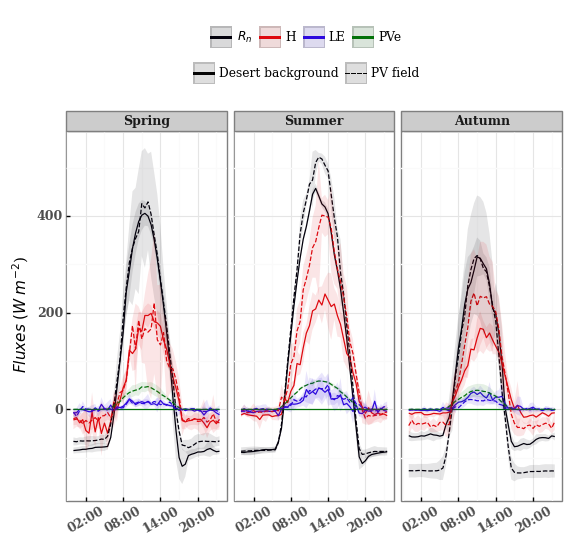

<ggplot: (-9223371992823696264)>

In [94]:
cbPalette = ["#02000B","#DE090F","#2D09DE", "#037209", "#80ff80", "#c2c2d6", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# Convert the times back to a “fake” timestamp:
all_df_diurnal['timestamp2'] = pd.to_datetime(all_df_diurnal['Time'], utc=True)


# Makes long format
temp_means = pd.melt(all_df_diurnal, id_vars=['Ecosystem','Season','Time','timestamp2'], value_vars=['H_mean','LE_mean','PVe_mean','Rn_mean'])
temp_sds = pd.melt(all_df_diurnal, id_vars=['Ecosystem','Season','Time','timestamp2'], value_vars=['H_sd','LE_sd','PVe_sd','Rn_sd'])

temp_means.rename(columns={'value': 'mean'}, inplace=True)
temp_sds.rename(columns={'value': 'sd'}, inplace=True)

temp_means['variable'] = temp_means['variable'].astype(str).str.replace('_mean', '')
temp_sds['variable'] = temp_means['variable'].astype(str).str.replace('_sd', '')

temp = temp_means.merge(temp_sds, on=['Ecosystem','Season','Time','timestamp2','variable'])

temp.loc[temp['variable'] == 'Rn', 'variable'] = '$R_n$'


plt = ggplot(temp)
plt = plt + geom_line(aes(x='timestamp2', y='mean',linetype='Ecosystem', color='variable'))
#plt = plt + geom_line(aes(x='timestamp2', y='LE_mean',linetype='Ecosystem'), colour='#234566')
plt = plt + geom_ribbon(aes(x='timestamp2', ymin='mean - sd', ymax='mean + sd',linetype='Ecosystem', fill='variable'), alpha=0.1)
plt = plt + labs(x='Hour', y='$Fluxes\; (W \; m^{-2}$)', parse=True)
plt = plt + facet_wrap(['Season'])
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(size=9,rotation=30,hjust=0.5,weight='bold'),
                  axis_title_x = element_blank(),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')
plt = plt + theme(legend_position = 'top')
#plt = plt + theme(legend_title = 'none')
plt = plt + scale_x_datetime(date_breaks = '6 hours', date_labels = '%H:%M')

plt.save(graphs_path + 'energy_budget.pdf', width=19, height=7, units='cm', scale=1.3, dpi=600)
plt.save(graphs_path + 'energy_budget.png', width=19, height=7, units='cm', scale=1.3, dpi=600)


plt

# t-tests

In [96]:
a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'H_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'H_mean']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('Autumn, H: P =', pvalue_text(t[1]))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'H_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'H_mean']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('Spring, H: P =', pvalue_text(t[1]))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'H_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'H_mean']
t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
print('Spring, H (paired): P =', pvalue_text(t[1]))



a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'H_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'H_mean']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('Summer, H: P =', pvalue_text(t[1]))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'LE_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'LE_mean']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('Autumn, LE: P =', pvalue_text(t[1]))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'LE_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'LE_mean']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('Spring, LE: P =', np.round(t[1],2))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'LE_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'LE_mean']
t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
print('Spring, LE (paired): P =', np.round(t[1],2))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'LE_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'LE_mean']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('Summer, LE: P =', pvalue_text(t[1]))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'LE_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'LE_mean']
t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
print('Summer, LE (paired): P =', np.round(t[1],2))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Rn_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Rn_mean']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('Autumn, Rn: P =', pvalue_text(t[1]))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Rn_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Rn_mean']
t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
print('Autumn, Rn (paired): P =', np.round(t[1],2))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Rn_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Rn_mean']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('Spring, Rn: P =', np.round(t[1],2))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Rn_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Rn_mean']
t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
print('Spring, Rn (paired): P =', np.round(t[1],2))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Rn_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Rn_mean']
t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('Summer, Rn: P =', pvalue_text(t[1]))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Rn_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Rn_mean']
t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
print('Spring, Rn (paired): P =', np.round(t[1],2))

Autumn, H: P = <.001
Spring, H: P = 0.34
Spring, H (paired): P = 0.22
Summer, H: P = <.001
Autumn, LE: P = <.001
Spring, LE: P = 0.83
Spring, LE (paired): P = 0.84
Summer, LE: P = 0.43
Summer, LE (paired): P = 0.22
Autumn, Rn: P = 0.93
Autumn, Rn (paired): P = 0.72
Spring, Rn: P = 0.79
Spring, Rn (paired): P = 0.12
Summer, Rn: P = <.001
Spring, Rn (paired): P = 0.0


In [84]:
mean_df = averaging(all_df).round(2)

# Move Season to the front
col = mean_df.pop('Season')
mean_df.insert(0, col.name, col)
# Create a text of summarised values (mean + stddev)
mean_df['H'] = mean_df['H_mean'].astype(int).astype(str) + ' (' + mean_df['H_sd'].astype(int).astype(str) + ')'
mean_df['LE_clean'] = mean_df['LE_clean_mean'].astype(int).astype(str) + ' (' + mean_df['LE_clean_sd'].astype(int).astype(str) + ')'
mean_df['PVe'] = mean_df['PVe_mean'].astype(int).astype(str) + ' (' + mean_df['PVe_sd'].astype(int).astype(str) + ')'
mean_df['Rn'] = mean_df['Rn_mean'].astype(int).astype(str) + ' (' + mean_df['Rn_sd'].astype(int).astype(str) + ')'

# Remove the original values
mean_df.drop(['H_mean','H_sd','LE_clean_mean','LE_clean_sd','PVe_mean','PVe_sd','Rn_mean','Rn_sd'], axis=1, inplace=True)
# Convert to wide format
mean_df = mean_df.pivot(index='Ecosystem', columns='Season').stack(level=[0])

mean_df.to_latex(output_path + 'Ketura_radiative_fluxes_new.tex', index=True)

display(mean_df)

Season                         Autumn     Spring    Summer
Ecosystem                                                 
Desert background H          142 (29)   171 (33)  198 (50)
                  LE_clean    29 (13)     14 (5)   34 (22)
                  PVe           0 (0)      0 (0)     0 (0)
                  Rn         259 (68)   348 (67)  409 (34)
PV field          H          216 (90)   157 (85)  343 (84)
                  LE_clean     20 (6)     14 (7)   37 (22)
                  PVe         33 (12)    40 (11)    54 (4)
                  Rn        253 (117)  356 (122)  475 (45)

In [22]:
# Remove values
# all_df.drop(['Sin'], axis=1, inplace=True)
# all_df.drop(['Time'], axis=1, inplace=True)
# all_df.drop(['Year'], axis=1, inplace=True)
display(all_df)

# Prepare table
final_df = mean_df.pivot(index='Season', columns='Ecosystem').stack(level=[0])

final_df = final_df.reset_index()

final_df['P'] = ''
final_df.rename(columns={'level_1': 'Parameter'}, inplace=True)
display(final_df)
p_df = ttest_all(all_df, 'Season', ['H','LE','Rn','PVe'], 'Ecosystem')

final_df = final_df.merge(p_df, on = ['Parameter', 'Season'], how='left').copy()

display(final_df)
final_df.to_latex(output_path + 'Ketura_non_radiative_fluxes_new.tex', index=False)

,DateTime,Season,Year,Ecosystem,H,LE,Rn,PVe,Sin,Sout,Lin,Lout,Time,Lout_from_drone
0,2019-07-09 20:30:00+00:00,Summer,2019,Desert background,NaN,NaN,-95.718048,0.0,0.0,0.038464,407.393005,503.072601,20:30,NaN
1,2019-07-09 21:00:00+00:00,Summer,2019,Desert background,-16.650749,NaN,-96.925995,0.0,0.0,0.000000,400.308990,497.234985,21:00,NaN
2,2019-07-09 21:30:00+00:00,Summer,2019,Desert background,-11.533690,18.102051,-96.224976,0.0,0.0,0.000000,396.226013,492.450989,21:30,NaN
3,2019-07-09 22:00:00+00:00,Summer,2019,Desert background,-21.672520,-17.746120,-94.640991,0.0,0.0,0.000000,393.476013,488.117004,22:00,NaN
4,2019-07-09 22:30:00+00:00,Summer,2019,Desert background,-13.702280,-0.758002,-92.843018,0.0,0.0,0.000000,391.584991,484.428009,22:30,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857,2018-11-01 05:30:00+00:00,NaN,NaN,PV field,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05:30,464.960754
1858,2018-11-01 06:00:00+00:00,NaN,NaN,PV field,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06:00,466.101837
1859,2018-11-01 06:30:00+00:00,NaN,NaN,PV field,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06:30,470.496307
1860,2018-11-01 07:00:00+00:00,NaN,NaN,PV field,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07:00,470.006592


KeyError: "None of ['Season', 'Ecosystem'] are in the columns"

In [23]:
diurnal_sum_ketura_df = diurnal_sum(all_df)

#display(diurnal_sum_ketura_df)


diurnal_sum_mast_df = diurnal_sum_ketura_df.loc[(diurnal_sum_ketura_df['Ecosystem']=='Desert background')]
diurnal_sum_pv_df = diurnal_sum_ketura_df.loc[(diurnal_sum_ketura_df['Ecosystem']=='PV field')]

diurnal_sum_desert_spring_df = diurnal_sum_ketura_df.loc[(diurnal_sum_ketura_df['Ecosystem']=='Desert background')&(diurnal_sum_ketura_df['Season']=='Spring')]
diurnal_sum_pv_spring_df = diurnal_sum_ketura_df.loc[(diurnal_sum_ketura_df['Ecosystem']=='PV field')&(diurnal_sum_ketura_df['Season']=='Spring')]

diurnal_sum_desert_summer_df = diurnal_sum_ketura_df.loc[(diurnal_sum_ketura_df['Ecosystem']=='Desert background')&(diurnal_sum_ketura_df['Season']=='Summer')]
diurnal_sum_pv_summer_df = diurnal_sum_ketura_df.loc[(diurnal_sum_ketura_df['Ecosystem']=='PV field')&(diurnal_sum_ketura_df['Season']=='Summer')]

diurnal_sum_desert_autumn_df = diurnal_sum_ketura_df.loc[(diurnal_sum_ketura_df['Ecosystem']=='Desert background')&(diurnal_sum_ketura_df['Season']=='Autumn')]
diurnal_sum_pv_autumn_df = diurnal_sum_ketura_df.loc[(diurnal_sum_ketura_df['Ecosystem']=='PV field')&(diurnal_sum_ketura_df['Season']=='Autumn')]

#diurnal_sum_desert_autumn_df.describe().round(2)
diurnal_sum_pv_autumn_df.describe().round(2)
#display(diurnal_sum_mast_df)
#display(diurnal_sum_pv_df)

NameError: name 'diurnal_sum' is not defined

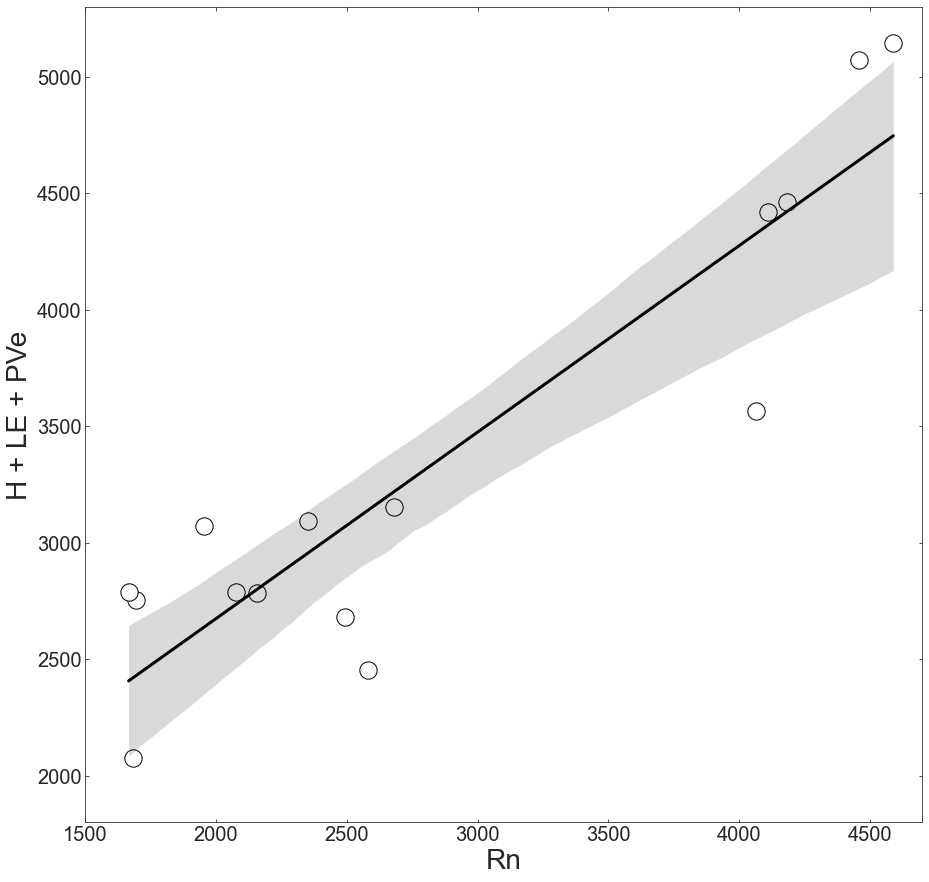

In [10]:
sns.set_style("ticks")
fig, axs = plt.subplots(ncols=1,nrows=1)
fig.set_size_inches(15, 15)
# control x and y limits
plt.ylim(1800, 5300)
plt.xlim(1500, 4700)
sns.set(font_scale = 1.8)
ax = sns.regplot(x='Rn_sum',y='H_LE_PVe_sum',marker="o",scatter_kws={"color":"white","alpha":1,"edgecolor":"black","s":300},line_kws={"color":"black","alpha":1,"lw":3},data=diurnal_sum_mast_df)
#sns.lmplot( x="Rn_sum", y="H_LE_PVe_sum", data=diurnal_sum_mast_df, hue='Month', legend=True)
ax.set_xlabel('Rn', fontsize=28)
ax.set_ylabel('H + LE + PVe',fontsize=28)
ax.tick_params(labelsize=20)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='both', direction = 'in',labeltop=False, labelright=False)

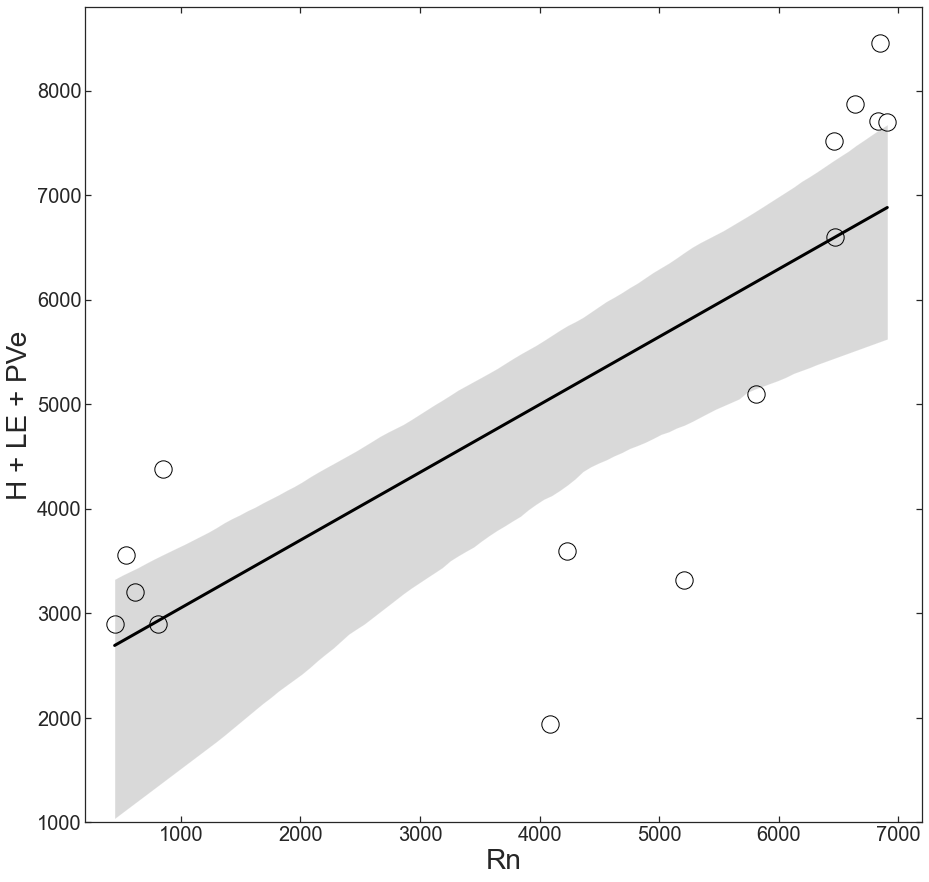

In [11]:
sns.set_style("ticks")
fig, axs = plt.subplots(ncols=1,nrows=1)
fig.set_size_inches(15, 15)
# control x and y limits
plt.ylim(1000, 8800)
plt.xlim(200, 7200)
sns.set(font_scale = 1.8)
ax = sns.regplot(x='Rn_sum',y='H_LE_PVe_sum',marker="o",scatter_kws={"color":"white","alpha":1,"edgecolor":"black","s":300},line_kws={"color":"black","alpha":1,"lw":3},data=diurnal_sum_pv_df)
#sns.lmplot( x="Rn_sum", y="H_LE_PVe_sum", data=diurnal_sum_mast_df, hue='Month', legend=True)
ax.set_xlabel('Rn', fontsize=28)
ax.set_ylabel('H + LE + PVe',fontsize=28)
ax.tick_params(labelsize=20)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='both', direction = 'in',labeltop=False, labelright=False)

'Regression line: y_desert=1073.47+0.80x_desert, r=0.91'

'Regression line: y_pv=2402.40+0.65x_pv, r=0.78'

,Ecosystem,EBR spring,EBR summer,EBR autumn,slope,intercept,rvalue,pvalue,stderr,r_text,eq_text
0,Desert background,$EBR \;spring = 1.07$,$EBR \;summer = 1.06$,$EBR \;autumn = 1.44$,0.800382,1073.469417,0.914132,0.000002,0.098451,$R^2 = 0.91$,$y = 0.8x + 1073.47$
0,PV field,$EBR \;spring = 0.65$,$EBR \;summer = 1.11$,$EBR \;autumn = 5.69$,0.648325,2402.404002,0.778366,0.000631,0.145033,$R^2 = 0.78$,$y = 0.65x + 2402.4$


C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 19.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: F:/Group members Rafael/Analyses/Ketura Solar/Tables/03_graphs/ebr.pdf
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\guides\guides.py:200: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:744: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "scale" which is no longer supported as of 3.3 and will become an error two minor releases later
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 19.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: F:/Group members R

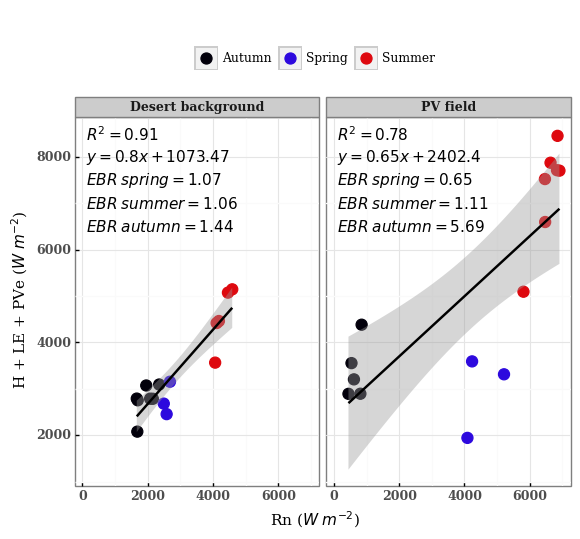

<ggplot: (-9223371986029085768)>

In [33]:
cbPalette = ["#02000B", "#2D09DE", "#DE090F", "#80ff80", "#c2c2d6", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

plt = ggplot(diurnal_sum_ketura_df)
plt = plt + theme_bw()
plt = plt + geom_point(aes(x='Rn_sum',y='H_LE_PVe_sum', color='Season'),size=4)
plt = plt + geom_smooth(aes(x='Rn_sum',y='H_LE_PVe_sum'),method='lm')
plt = plt + labs(x='Rn ($W \; m^{-2}$)', y='H + LE + PVe ($W \; m^{-2}$)',color='', parse=True)
plt = plt + facet_wrap(['Ecosystem'])
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme(axis_text_x=element_text(size=9,weight='bold'),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')

plt = plt + theme(legend_position = 'top')
x_desert = diurnal_sum_mast_df['Rn_sum']
y_desert = diurnal_sum_mast_df['H_LE_PVe_sum']
slope, intercept, r, p, stderr = scipy.stats.linregress(x_desert, y_desert)
line_desert = f'Regression line: y_desert={intercept:.2f}+{slope:.2f}x_desert, r={r:.2f}'
#print(scipy.stats.linregress(x_desert,y_desert))
display(line_desert)

x_pv = diurnal_sum_pv_df['Rn_sum']
y_pv = diurnal_sum_pv_df['H_LE_PVe_sum']
slope, intercept, r, p, stderr = scipy.stats.linregress(x_pv, y_pv)
line_pv = f'Regression line: y_pv={intercept:.2f}+{slope:.2f}x_pv, r={r:.2f}'
#print(scipy.stats.linregress(x_pv,y_pv))
display(line_pv)

coefficients = pd.DataFrame([scipy.stats.linregress(x_desert, y_desert)])
coefficients = coefficients.append(pd.DataFrame([scipy.stats.linregress(x_pv, y_pv)]))
coefficients.insert(loc=0, column='Ecosystem', value=['Desert background','PV field'])
coefficients.insert(loc=1, column='EBR spring', value=['1.07','0.65'])
coefficients.insert(loc=2, column='EBR summer', value=['1.06','1.11'])
coefficients.insert(loc=3, column='EBR autumn', value=['1.44','5.69'])
#coefficients.insert(loc=1, column='EBR', value=[ebr_desert,'PV field'])
coefficients['r_text'] = '$R^2 = ' + coefficients['rvalue'].round(2).astype(str) + '$'
coefficients['eq_text'] = '$y = ' + coefficients['slope'].round(2).astype(str) + 'x + ' + coefficients['intercept'].round(2).astype(str) + '$'
coefficients['EBR spring'] = '$EBR \;spring = ' + coefficients['EBR spring'].astype(str) + '$'
coefficients['EBR summer'] = '$EBR \;summer = ' + coefficients['EBR summer'].astype(str) + '$'
coefficients['EBR autumn'] = '$EBR \;autumn = ' + coefficients['EBR autumn'].astype(str) + '$'
display(coefficients)

plt = plt + geom_text(aes(x=100, y = 8500, label='r_text'), data=coefficients, inherit_aes=False, ha='left')
plt = plt + geom_text(aes(x=100, y = 8000, label='eq_text'), data=coefficients, inherit_aes=False, ha='left')
plt = plt + geom_text(aes(x=100, y = 7500, label='EBR spring'), data=coefficients, inherit_aes=False, ha='left')
plt = plt + geom_text(aes(x=100, y = 7000, label='EBR summer'), data=coefficients, inherit_aes=False, ha='left')
plt = plt + geom_text(aes(x=100, y = 6500, label='EBR autumn'), data=coefficients, inherit_aes=False, ha='left')

#plt = plt + annotate('text', x=200, y = 8500, label='EBR')

plt.save(graphs_path + 'ebr.pdf', width=19, height=10, units='cm', scale=1.3, dpi=600)
plt.save(graphs_path + 'ebr.png', width=19, height=10, units='cm', scale=1.3, dpi=600)


plt

In [39]:
coefficients = pd.DataFrame([scipy.stats.linregress(x_desert, y_desert)])
coefficients = coefficients.append( pd.DataFrame([scipy.stats.linregress(x_pv, y_pv)]) )
coefficients.insert(loc=0, column='Ecosystem', value=['Desert background','PV field'])
display(coefficients)

,Ecosystem,slope,intercept,rvalue,pvalue,stderr
0,Desert background,0.800382,1073.469417,0.914132,0.000002,0.098451
0,PV field,0.646213,2425.716254,0.776236,0.000668,0.145564


In [120]:
solar_july_df = EBR_calc(all_df, 'Solar', 7)
solar_july_df.sum()

,DateTime,Month,Year,Ecosystem,H_LE_PVe,Rn
376,2019-07-16 15:00:00+00:00,7,2019,Solar,466.784180,457.016479
377,2019-07-16 15:30:00+00:00,7,2019,Solar,357.005737,397.395020
378,2019-07-16 16:00:00+00:00,7,2019,Solar,379.357727,335.164368
379,2019-07-16 16:30:00+00:00,7,2019,Solar,266.512360,268.288208
380,2019-07-16 17:00:00+00:00,7,2019,Solar,209.936356,191.173706
...,...,...,...,...,...,...
745,2019-07-24 07:30:00+00:00,7,2019,Solar,52.343498,114.438202
746,2019-07-24 08:00:00+00:00,7,2019,Solar,77.384583,183.038818
747,2019-07-24 08:30:00+00:00,7,2019,Solar,125.510437,253.014648
748,2019-07-24 09:00:00+00:00,7,2019,Solar,183.371841,326.860962


Month                                                     2618
Year                                                    755106
Ecosystem    SolarSolarSolarSolarSolarSolarSolarSolarSolarS...
H_LE_PVe                                               53570.9
Rn                                                     46771.6
dtype: object

In [122]:
solar_october_df = EBR_calc(all_df, 'Solar', 10)
solar_october_df.sum()

,DateTime,Month,Year,Ecosystem,H_LE_PVe,Rn
65,2018-10-25 21:00:00+00:00,10,2018,Solar,-39.782410,-123.955566
66,2018-10-25 21:30:00+00:00,10,2018,Solar,-42.374668,-122.132385
67,2018-10-25 22:00:00+00:00,10,2018,Solar,-44.105091,-119.571411
68,2018-10-25 22:30:00+00:00,10,2018,Solar,-41.815186,-122.086487
69,2018-10-25 23:00:00+00:00,10,2018,Solar,-46.320400,-120.905457
...,...,...,...,...,...,...
347,2018-10-31 18:00:00+00:00,10,2018,Solar,-51.639183,-135.502655
348,2018-10-31 18:30:00+00:00,10,2018,Solar,-73.754898,-134.077728
349,2018-10-31 19:00:00+00:00,10,2018,Solar,-54.596062,-132.313202
350,2018-10-31 19:30:00+00:00,10,2018,Solar,-35.437222,-134.721069


Month                                                     2870
Year                                                    579166
Ecosystem    SolarSolarSolarSolarSolarSolarSolarSolarSolarS...
H_LE_PVe                                               20564.9
Rn                                                      3973.3
dtype: object

In [123]:
solar_march_df = EBR_calc(all_df, 'Solar', 'March')
solar_march_df.sum()

,DateTime,Month,Year,Ecosystem,H_LE_PVe,Rn
860,2018-03-22 19:00:00+00:00,March,2018,Solar,-18.689117,-99.251678
861,2018-03-22 19:30:00+00:00,March,2018,Solar,-24.444883,-95.421051
862,2018-03-22 20:00:00+00:00,March,2018,Solar,-29.765491,-80.351013
863,2018-03-22 20:30:00+00:00,March,2018,Solar,-17.806971,-74.197479
864,2018-03-22 21:00:00+00:00,March,2018,Solar,-13.553759,-74.715637
...,...,...,...,...,...,...
1089,2018-03-27 13:30:00+00:00,March,2018,Solar,85.742844,143.913605
1090,2018-03-27 14:00:00+00:00,March,2018,Solar,48.749916,94.802673
1091,2018-03-27 14:30:00+00:00,March,2018,Solar,46.460754,145.048431
1092,2018-03-27 15:00:00+00:00,March,2018,Solar,38.999306,130.964203


Month        MarchMarchMarchMarchMarchMarchMarchMarchMarchM...
Year         2018201820182018201820182018201820182018201820...
Ecosystem    SolarSolarSolarSolarSolarSolarSolarSolarSolarS...
H_LE_PVe                                               9616.95
Rn                                                     13647.4
dtype: object

In [125]:
desert_october_df = EBR_calc(all_df, 'Desert', 'October')
desert_october_df.sum()

,DateTime,Month,Year,Ecosystem,H_LE_PVe,Rn
480,2018-10-16 15:00:00+00:00,October,2018,Desert,142.663330,273.016876
481,2018-10-16 15:30:00+00:00,October,2018,Desert,104.268303,26.787659
482,2018-10-16 16:00:00+00:00,October,2018,Desert,84.944168,-17.770905
483,2018-10-16 16:30:00+00:00,October,2018,Desert,29.608416,-75.164429
484,2018-10-16 17:00:00+00:00,October,2018,Desert,4.358870,-85.197662
...,...,...,...,...,...,...
844,2018-10-24 05:00:00+00:00,October,2018,Desert,-20.246632,-47.483582
845,2018-10-24 05:30:00+00:00,October,2018,Desert,-29.652836,-47.363708
846,2018-10-24 06:00:00+00:00,October,2018,Desert,-34.660286,-18.891479
847,2018-10-24 06:30:00+00:00,October,2018,Desert,-30.895613,-116.002960


Month        OctoberOctoberOctoberOctoberOctoberOctoberOcto...
Year         2018201820182018201820182018201820182018201820...
Ecosystem    DesertDesertDesertDesertDesertDesertDesertDese...
H_LE_PVe                                               19600.9
Rn                                                     12427.9
dtype: object

In [126]:
desert_march_df = EBR_calc(all_df, 'Desert', 'March')
desert_march_df.sum()

,DateTime,Month,Year,Ecosystem,H_LE_PVe,Rn
288,2018-03-18 19:30:00+00:00,March,2018,Desert,-6.189427,-83.025940
289,2018-03-18 20:00:00+00:00,March,2018,Desert,-3.873590,-77.351105
290,2018-03-18 20:30:00+00:00,March,2018,Desert,-20.974201,-77.527710
291,2018-03-18 21:00:00+00:00,March,2018,Desert,-15.091703,-77.836975
292,2018-03-18 21:30:00+00:00,March,2018,Desert,-4.173401,-64.100677
...,...,...,...,...,...,...
453,2018-03-22 06:00:00+00:00,March,2018,Desert,-24.058813,-63.644592
454,2018-03-22 06:30:00+00:00,March,2018,Desert,-9.071456,-18.770630
455,2018-03-22 07:00:00+00:00,March,2018,Desert,14.214428,37.049469
456,2018-03-22 07:30:00+00:00,March,2018,Desert,48.840424,94.986328


Month        MarchMarchMarchMarchMarchMarchMarchMarchMarchM...
Year         2018201820182018201820182018201820182018201820...
Ecosystem    DesertDesertDesertDesertDesertDesertDesertDese...
H_LE_PVe                                               7858.24
Rn                                                      6187.6
dtype: object

In [127]:
desert_july_df = EBR_calc(all_df, 'Desert', 'July')
desert_july_df.sum()

,DateTime,Month,Year,Ecosystem,H_LE_PVe,Rn
2,2019-07-09 21:30:00+00:00,July,2019,Desert,6.568360,-96.224976
3,2019-07-09 22:00:00+00:00,July,2019,Desert,-39.418640,-94.640991
4,2019-07-09 22:30:00+00:00,July,2019,Desert,-14.460282,-92.843018
5,2019-07-09 23:00:00+00:00,July,2019,Desert,-8.896470,-92.238007
6,2019-07-09 23:30:00+00:00,July,2019,Desert,-9.067801,-92.449982
...,...,...,...,...,...,...
279,2019-07-15 16:00:00+00:00,July,2019,Desert,248.915131,253.736633
280,2019-07-15 16:30:00+00:00,July,2019,Desert,203.390564,209.505493
281,2019-07-15 17:00:00+00:00,July,2019,Desert,173.223969,155.924072
282,2019-07-15 17:30:00+00:00,July,2019,Desert,175.871429,97.510559


Month        JulyJulyJulyJulyJulyJulyJulyJulyJulyJulyJulyJu...
Year         2019201920192019201920192019201920192019201920...
Ecosystem    DesertDesertDesertDesertDesertDesertDesertDese...
H_LE_PVe                                               27773.8
Rn                                                     26467.5
dtype: object